In [11]:
import numpy as np
import json
import ast
import math
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

punctuations = ['.', '!', ',', '}', '{', ']', '[', '=', '*', '+', ':', '\"', '\"', ')', '(']

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 

def remove_punctuation(tx):
    for i in punctuations:
        tx = tx.replace(i, '')
    return tx

def tokenize(text):
    prepared_text = text.split(' ')
    prepared_text = [remove_punctuation(i) for i in prepared_text if i not in punctuations]
    return prepared_text


def read_data(address):

        with open(address) as f:
            data = ast.literal_eval(f.read())

        return data
    


def get_words(doc, method='none'):
    text = doc['title'] + " " + doc['body']
    if method == 'none':
        tokens = tokenize(text)
        return tokens
    elif method == 'lemmatization':
        
        tokens = tokenize(text)
        tokens = [lemmatizer.lemmatize(i) for i in tokens]
        return tokens
    elif method == 'stopword_removal':
        tokens = tokenize(text)
        tokens = [i for i in tokens if i not in stop_words]
        return tokens
    elif method == 'stemming':
        tokens = tokenize(text)
        tokens = [ps.stem(i) for i in tokens if i not in stop_words]
        return tokens




def create_corpus(method='none'):
    index = 0
    
    all_corpus = {}

    for doc in training_data[: training_length]:

        
        tokens = get_words(doc, method)
        for t in tokens: 
            if t not in all_corpus:
                all_corpus[t] = index
                index += 1
        tokens = list(set(tokens))
        for t in tokens:
            if t in idf:
                idf[t] += 1
            else:
                idf[t] = 1
    for i in idf:     
        idf[i] = math.log(training_length / idf[i], 10)
    
    return all_corpus  

def create_training_vectors(method='none'):
    
    
    for i in range(training_length):
        doc = training_data[i]
        training_data_categories.append(doc['category'] - 1)
        tokens = get_words(doc, method)
        for t in tokens:   
            if t in corpus_tfidf:
                training_data_vectors[i][corpus_tfidf[t]] += (1 * idf[t])
    
            
            

def create_validation_vectors(method='none'):
    
    for i in range(validation_length):
        
        doc = validation_data[i]
        validation_data_categories.append(doc['category'] - 1)
        tokens = get_words(doc, method)
        for t in tokens:
            if t in corpus_tfidf:
                
                validation_data_vectors[i][corpus_tfidf[t]] += (1 * idf[t])
            
    
            



training_data = read_data('data/train.json')
validation_data = read_data('test_1000.json')
create_validation_vectors()



In [9]:

def accuracy(original, predicted):
    accuracy = 0
    for i in range(len(original)):
        if original[i] == predicted[i]:
            accuracy += 1
    
    return accuracy/len(original)

def recall(original, predicted, num_of_class):
    
    all_in_class = 0
    tp = 0
    for i in range(len(predicted)):
        if predicted[i] == num_of_class and original[i] == num_of_class:
            tp += 1
        if original[i] == num_of_class:
            all_in_class += 1
    return tp/all_in_class

def precision(original, predicted, num_of_class):
    tp = 0
    reterieved = 0
    for i in range(len(predicted)):
        if predicted[i] == num_of_class and original[i] == num_of_class:
            tp += 1
        if predicted[i] == num_of_class:
            reterieved += 1
    return tp/reterieved


   
def f_measeure(original, predicted, num_of_classess):
    f1s = [0 for i in range(num_of_classess)]
    #beta = 1 and alpha = 0.5
    for i in range(num_of_classess):
        pr = precision(original, predicted, i)
        rec = recall(original, predicted, i)
        if not (pr + rec) == 0:
            
            f1s[i] = (2 * pr * rec)/(pr + rec)
    
    average = 0
    for i in f1s:
        average += i
    return average/num_of_classess

def confusion_matrix(original, predicted, num_of_classess):
    cf = [[0 for i in range(num_of_classess)] for j in range(num_of_classess)]
    
    for i in range(len(original)):
        cf[original[i]][predicted[i]] += 1
    return cf

def all_measures(original, predicted):
    


    print("Accuracy is: " + str(accuracy(original, predicted)))

    print("Macro Averaged F1 Measure is: " + str(f_measeure(original, predicted, 4)))

    print("Confusion Matrix is:")
    print(np.array(confusion_matrix(original, predicted, 4)))

    for i in range(4):
        print('Recall for group ' + str(i + 1) + ' : ' + str(recall(original, predicted, i)))
    for i in range(4):
        print('Precision for group ' + str(i + 1) + ' : ' + str(precision(original, predicted, i)))




impelementing KNN with two distance functions

In [3]:

def find_majority(vector):  
      
        accurences = [0 for i in range(4)]
        for i in vector:
           
            accurences[training_data_categories[i]] += 1
        return accurences.index(max(accurences))

def cosine_similarity():
    training_norms = np.array([np.linalg.norm(i) for i in training_data_vectors])
    validation_norms = np.array([np.linalg.norm(i) for i in validation_data_vectors])
    #print(len(training_data_vectors), len(validation_data_vectors/validation_norms))

    cosine = np.matmul(training_data_vectors/training_norms[:, None],
                   np.transpose(validation_data_vectors/validation_norms[:, None]))
    predicted = []
    for i in range(len(cosine[0])):    
        dist = np.argpartition(cosine[ :, i], -k)[-k: ]
        predicted.append(find_majority(dist))
        
    return predicted

def euclidean_similarity():
    
    predicted = []
    dot = -2 * np.matmul(training_data_vectors,
                   np.transpose(validation_data_vectors))
    
   
    for i in range(training_length):
        dot[i] += np.sum(np.abs(training_data_vectors[i])**2,axis=-1)
    for i in range(validation_length):
        dot[:, i] += np.sum(np.abs(validation_data_vectors[i])**2,axis=-1)
    for i in range(len(dot[0])):   
        
        dist = np.argpartition(dot[ :, i], k)[: k]
        predicted.append(find_majority(dist))
        
    return predicted


k = 5

training_data_categories = []
validation_data_categories = []
idf= {}
training_length = len(training_data)
validation_length = len(validation_data)
corpus_tfidf = {}
corpus_tfidf = create_corpus(method='stopword_removal')



training_data_vectors = np.zeros(shape=(training_length, len(corpus_tfidf)))
validation_data_vectors = np.zeros(shape=(validation_length, len(corpus_tfidf)))
create_training_vectors()
create_validation_vectors()



predicted = cosine_similarity()
all_measures(validation_data_categories, predicted)


#euclidean_predicted = euclidean_similarity()

#print(accuracy(validation_data_categories, euclidean_predicted))



implementing Naive Bayes

In [12]:
create_training_vectors()
create_validation_vectors()
def update_corpus(tokens, category):

        for word in tokens:
            if word in corpus:
                corpus[word][category] += 1
                corpus[word]["total"] += 1
            else:
                corpus[word] = {0: 0, 1: 0, 2: 0, 3: 0, 'total': 1}
                corpus[word][category] += 1
                


def train(method='none'):
        for doc in training_data:
            tokens = get_words(doc, method)
            
            update_corpus(tokens, doc['category'] - 1)

        for word in corpus:
            for i in range(num_of_classes):
                corpus[word][i] = (corpus[word][i] + alpha) / \
                                       (corpus[word]['total'] + len(corpus) * alpha)



            
def test(method='none'):    
        predicted = []
        for j in range(len(validation_data)):
            tokens = get_words(validation_data[j], method)
            
            props = [i for i in probabilities_ck]
           
            for word in tokens:

                for i in range(4):
                    if word in corpus:
                        
                        props[i] += corpus[word][i]
            
            predicted.append(props.index(max(props)))


        return predicted
    
def calculate_ck():
    probabilities_ck = [0 for i in range(4)]
    for i in training_data_categories:
        probabilities_ck[i] += 1
    for i in range(4):
        probabilities_ck[i] = probabilities_ck[i]/len(training_data_categories)
    return probabilities_ck

validation_data_categories = []
for v in validation_data:
    validation_data_categories.append(v['category'] - 1)


num_of_classes = 4
alpha = 0.00001
corpus = {}
probabilities_ck = calculate_ck()

train('none')
predicted = test('none')
print(accuracy(predicted, validation_data_categories), ' No Processing')

corpus = {}
train('lemmatization')
predicted = test('lemmatization')
print(accuracy(predicted, validation_data_categories), ' lemmatization')

corpus = {}
train('stemming')
predicted = test('stemming')
print(accuracy(predicted, validation_data_categories), ' stemming')

corpus = {}
train('stopword_removal')
predicted = test('stopword_removal')
print('Measures for Stopword Removal: ')
all_measures(validation_data_categories, predicted)





0.894  No Processing
0.895  lemmatization
0.903  stemming
Measures for Stopword Removal: 
Accuracy is: 0.902
Macro Averaged F1 Measure is: 0.9002244410173318
Confusion Matrix is:
[[218   9  13   6]
 [  4 259   1   1]
 [  8   4 202  15]
 [ 12   2  23 223]]
Recall for group 1 : 0.8861788617886179
Recall for group 2 : 0.9773584905660377
Recall for group 3 : 0.8820960698689956
Recall for group 4 : 0.8576923076923076
Precision for group 1 : 0.9008264462809917
Precision for group 2 : 0.9452554744525548
Precision for group 3 : 0.8451882845188284
Precision for group 4 : 0.9102040816326531


implementing linear svm

In [ ]:
from sklearn import svm

training_data_categories = []
validation_data_categories = []
idf= {}
training_length = len(training_data)//2
validation_length = len(validation_data)//2
corpus_tfidf = {}
corpus_tfidf = create_corpus(method='none')



training_data_vectors = np.zeros(shape=(training_length, len(corpus_tfidf)))
validation_data_vectors = np.zeros(shape=(validation_length, len(corpus_tfidf)))
create_training_vectors()
create_validation_vectors()




clf = svm.SVC(kernel='linear', C=0.01)

clf.fit(training_data_vectors, training_data_categories)

y_pred = clf.predict(validation_data_vectors[:validation_length])
all_measures(validation_data[:validation_length], y_pred)


implementing random forest

In [5]:
from sklearn.ensemble import RandomForestClassifier

training_data_categories = []
validation_data_categories = []
idf= {}
training_length = len(training_data)
validation_length = len(validation_data)
corpus_tfidf = {}
corpus_tfidf = create_corpus(method='none')



training_data_vectors = np.zeros(shape=(training_length, len(corpus_tfidf)))
validation_data_vectors = np.zeros(shape=(validation_length, len(corpus_tfidf)))
create_training_vectors()
create_validation_vectors()


rf = RandomForestClassifier(n_estimators = 2000, random_state = 0, max_depth = 7)
rf.fit(training_data_vectors, training_data_categories);
predicted = rf.predict(validation_data_vectors)

all_measures(validation_data_categories, predicted)


Accuracy is: 0.811
Macro Averaged F1 Measure is: 0.8092160177787819
Confusion Matrix is:
[[604  64  29  53]
 [ 10 716   4  20]
 [ 47  39 532 132]
 [ 43  61  65 581]]
Recall for group 1 : 0.8053333333333333
Recall for group 2 : 0.9546666666666667
Recall for group 3 : 0.7093333333333334
Recall for group 4 : 0.7746666666666666
Precision for group 1 : 0.8579545454545454
Precision for group 2 : 0.8136363636363636
Precision for group 3 : 0.8444444444444444
Precision for group 4 : 0.7391857506361323


implementing K-means

In [3]:
training_data_categories = []
validation_data_categories = []
idf= {}
training_length = len(training_data)
validation_length = len(validation_data)
corpus_tfidf = {}
corpus_tfidf = create_corpus(method='stopword_removal')



training_data_vectors = np.zeros(shape=(training_length, len(corpus_tfidf)))
validation_data_vectors = np.zeros(shape=(validation_length, len(corpus_tfidf)))
create_training_vectors()
create_validation_vectors()


In [22]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random        
        
def initialize_centers(data):
    #centroids = [np.random.uniform(low=0, high=10, size=(len(training_data_vectors[0]),)) for i in range(self.k)]
    #rands = [random.randint(0, len(data) - 1) for i in range(4)]
    #print(rands)
    labels = [0, 2, 1, 3]
    rands = [0, 5, 7, 6]
    centers = [data[i] for  i in rands]
    #centers = [data[0], data[5], data[7], data[6]]
    #print(training_data_categories[0], training_data_categories[5], training_data_categories[7], training_data_categories[6])
    for i in range(4):
        assignments[rands[i]] = labels[i]
    return centers
    
             
def find_nearest_center(doc):
    nearest = -1
    distance = 10**6
    for i in range(k):
        dist = np.linalg.norm(doc - centroids[i])
        if dist < distance:             
            distance = dist
            nearest = i
    return nearest
    
def set_new_centroids(data):
    class_sizes = [0 for i in range(k)]
    
    x =  np.zeros(shape=(4, len(data[0])))
    for i in range(len(data)):
           
        x[assignments[i]] += data[i]
        class_sizes[assignments[i]] += 1
    for i in range(k):
        if class_sizes[i] != 0:
            centroids[i] = x[i]/class_sizes[i]
   
               
def iterate(data):
    j = 0
    while True:
        j += 1
        change = False
        for i in range(len(data)):
            new_center = find_nearest_center(data[i])
            
            if new_center != assignments[i]:
                change = True
                assignments[i] = new_center
            
        if change == False:
            print(j)
            return    
        set_new_centroids(data)
            


k = 4
assignments = [-1 for i in range(training_length)]
centroids = initialize_centers(training_data_vectors)  
iterate(training_data_vectors)




x = [0 for i in range(4)]
for i in assignments:
    x[i] += 1
print(x)







7
[1, 147, 240, 23612]


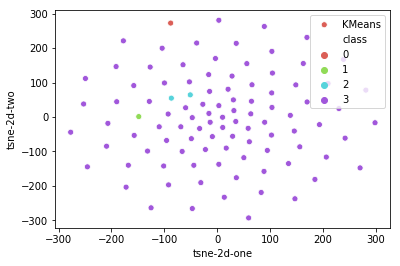

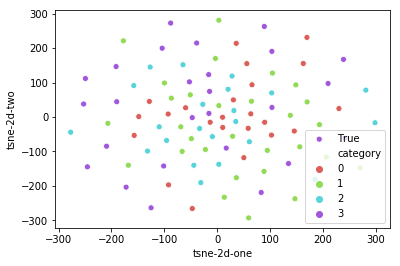

In [23]:
        
X_embedded = TSNE(n_components=2).fit_transform(training_data_vectors[:100])
feat_cols = [ 'column'+str(i) for i in range(len(training_data_vectors[0])) ]
df =  pd.DataFrame(training_data_vectors[:100],columns=feat_cols)

df_subset = df.loc[:100].copy()
data_subset = df_subset[feat_cols].values
df_subset['category'] = training_data_categories[:100]

df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two']  = X_embedded[:,1]



df_subset['class'] = assignments[:100]


ax = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue= "class", label="KMeans",
                     data=df_subset, palette=sns.color_palette("hls", 4),)
plt.show()

ax = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue= "category", label="True",
                     data=df_subset, palette=sns.color_palette("hls", 4),)
                     


using word2vec to reduce the dimention of the data

In [20]:
import gensim
import os


def get_word2vec(sentences, location):
    
    
    
    
    model = gensim.models.Word2Vec(sentences, size=embed_size, window=5, workers=4, min_count=1)
    
    print('Model done training')
    return model


embed_size =  300
docs = []
for doc in training_data:
    docs.append(get_words(doc, "none"))

w2vec = get_word2vec(docs, 'w2vmodel')



w2vecs = []
for i in range(training_length):
    new_vec = np.array([0. for i in range(embed_size)])
    for t in docs[i]:
        new_vec += w2vec.wv[t]
    new_vec = new_vec / len(docs[i])
    
    w2vecs.append(new_vec)
    
#print(w2vecs[0])




k = 4
assignments = [-1 for i in range(training_length)]
centroids = initialize_centers(w2vecs)
iterate(np.array(w2vecs))



x = [0 for i in range(4)]
for i in assignments:
    x[i] += 1
print(x)

Model done training
88
[6623, 7695, 6101, 3581]


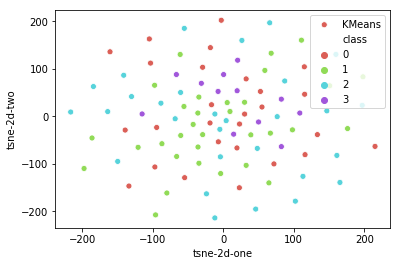

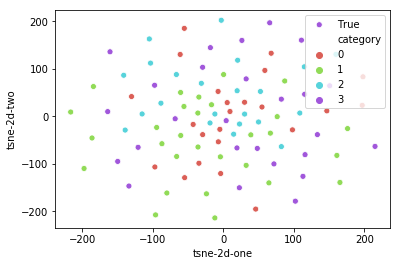

In [21]:
        
X_embedded = TSNE(n_components=2).fit_transform(training_data_vectors[:100])
feat_cols = [ 'column'+str(i) for i in range(len(training_data_vectors[0])) ]
df =  pd.DataFrame(training_data_vectors[:100],columns=feat_cols)

df_subset = df.loc[:100].copy()
data_subset = df_subset[feat_cols].values
df_subset['category'] = training_data_categories[:100]

df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two']  = X_embedded[:,1]



df_subset['class'] = assignments[:100]
#print(df_subset)

ax = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue= "class",  label="KMeans",
                     data=df_subset, palette=sns.color_palette("hls", 4),)
plt.show()

ax = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue= "category", label="True" ,
                     data=df_subset, palette=sns.color_palette("hls", 4),)
                     
